In [27]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import math

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [40,12]
matplotlib.rcParams['font.size'] = 20
np.random.seed(42)



**Import Data**

This dataset is about daily-minimum-temperatures time-series of [Kaggle](https://www.kaggle.com/shenba/time-series-datasets)

In [2]:
df=pd.read_csv('data\data.csv')

In [3]:
df.shape

(3650, 2)

In [4]:
df.head()

,Date,Daily minimum temperatures
0,01/01/1981,20.70
1,01/02/1981,17.90
2,01/03/1981,18.80
3,01/04/1981,14.60
4,01/05/1981,15.80


In [5]:
#delete column
df=df.drop('Date',axis=1)

In [6]:
#convert to 'str' and replace '?' to '0'
df.astype('str').dtypes
df.head()

,Daily minimum temperatures
0,20.70
1,17.90
2,18.80
3,14.60
4,15.80


In [7]:
df["Daily minimum temperatures"]=df["Daily minimum temperatures"].str.replace('?','0')

In [8]:
#create the predictive variable
df["Daily_min_temp_before"] = df["Daily minimum temperatures"].shift(-1)

In [9]:
df.tail()

,Daily minimum temperatures,Daily_min_temp_before
3645,14.00,13.60
3646,13.60,13.50
3647,13.50,15.70
3648,15.70,13.00
3649,13.00,NaN


In [10]:
#delete the row number 3649
df=df.drop(3649)

In [11]:
df.tail()

,Daily minimum temperatures,Daily_min_temp_before
3644,14.60,14.00
3645,14.00,13.60
3646,13.60,13.50
3647,13.50,15.70
3648,15.70,13.00


In [12]:
#create inputs and outputs variables
X=pd.to_numeric(df['Daily minimum temperatures'])
y=pd.to_numeric(df['Daily_min_temp_before'])
df_copy=pd.DataFrame(X)

**Scaling data**

In [13]:
from sklearn.preprocessing import StandardScaler

#applying standarscaler on X and y variables.
scaler=StandardScaler()
X_scaled=scaler.fit_transform(np.array(X).reshape(-1, 1))
y_scaled=scaler.transform(np.array(y).reshape(-1, 1))

Data


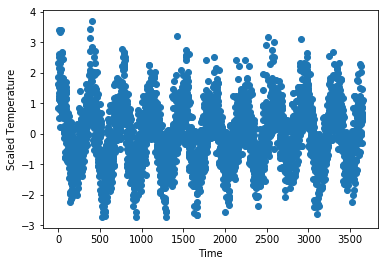

In [14]:
print('Data')
plt.xlabel("Time")
plt.ylabel("Scaled Temperature")
matplotlib.pyplot.scatter(range(X_scaled.shape[0]),X_scaled);

In [15]:
#split data into training and testing data
split_train=0.7
shape_train=int(np.round(X_scaled.shape[0]*split_train))
X_train,y_train=X_scaled[:shape_train],y_scaled[:shape_train]
X_test,y_test=X_scaled[shape_train:],y_scaled[shape_train:]

In [16]:
#reshape is necessary
X_train = np.array(X_train).reshape(-1,1,1)
X_test = np.array(X_test).reshape(-1,1,1)

In [17]:
X_train.shape,X_test.shape

((2554, 1, 1), (1095, 1, 1))

In [18]:
from keras.models import Sequential
from keras.layers import Dense,GRU,ConvLSTM2D 
from keras.optimizers import SGD,RMSprop

#create the model
model = Sequential()
model.add(GRU(300, dropout=0, input_shape=(1, 1),activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros'))
model.add(Dense(1))
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 300)               271800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 272,101
Trainable params: 272,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
#compile and fit the model
model.compile(loss='mean_squared_error', 
              optimizer='sgd', #'adam', 
              metrics=['mean_squared_error'])

his=model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1);

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2554/2554 [==============================] - 1s 551us/step - loss: 0.8289 - mean_squared_error: 0.8289
Epoch 2/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.6167 - mean_squared_error: 0.6167
Epoch 3/20
2554/2554 [==============================] - 0s 110us/step - loss: 0.5070 - mean_squared_error: 0.5070
Epoch 4/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.4544 - mean_squared_error: 0.4544
Epoch 5/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.4308 - mean_squared_error: 0.4308
Epoch 6/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.4210 - mean_squared_error: 0.4210
Epoch 7/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.4170 - mean_squared_error: 0.4170
Epoch 8/20
2554/2554 [==============================] - 0s 116us/step - loss: 0.4154 - mean_squared_error: 0.4154
Epoch 9/20
2554/2554 [==================

Plot the RMSE error during the fitting


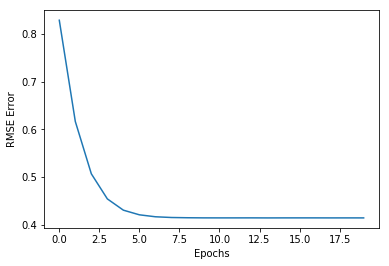

In [20]:
print('Plot the RMSE error during the fitting')
plt.xlabel("Epochs")
plt.ylabel("RMSE Error")
plt.plot(his.history['mean_squared_error']);

In [21]:
from sklearn.metrics import mean_squared_error

#applying inverse_tranforn on data by compute the error 
train_pred = scaler.inverse_transform(model.predict(X_train))
y_train_original = scaler.inverse_transform(y_train)
error_train = np.sqrt(mean_squared_error(y_train_original, train_pred))

print('RMSE error on training data: ', error_train)

RMSE error on training data:  2.6210835624072155


In [22]:
test_pred = scaler.inverse_transform(model.predict(X_test))
y_test_original = scaler.inverse_transform(y_test)
error_test = np.sqrt(mean_squared_error(y_test_original, test_pred))

print('RMSE error on training data: ', error_test)

RMSE error on training data:  2.447254765894851


In [23]:
#concatenate predicted outputs and ceros by plot the results
test_pred_plot = np.zeros(y.shape)
test_pred_plot[-test_pred.shape[0]:] = test_pred[:,0]
test_pred_plot[:-test_pred.shape[0]] = np.nan

data


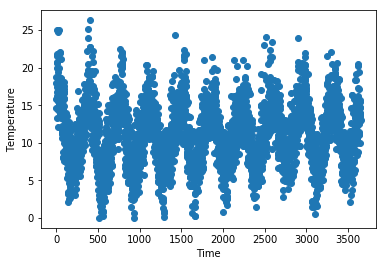

In [24]:
print('data')
plt.xlabel("Time")
plt.ylabel("Temperature")
matplotlib.pyplot.scatter(range(y.shape[0]),y);

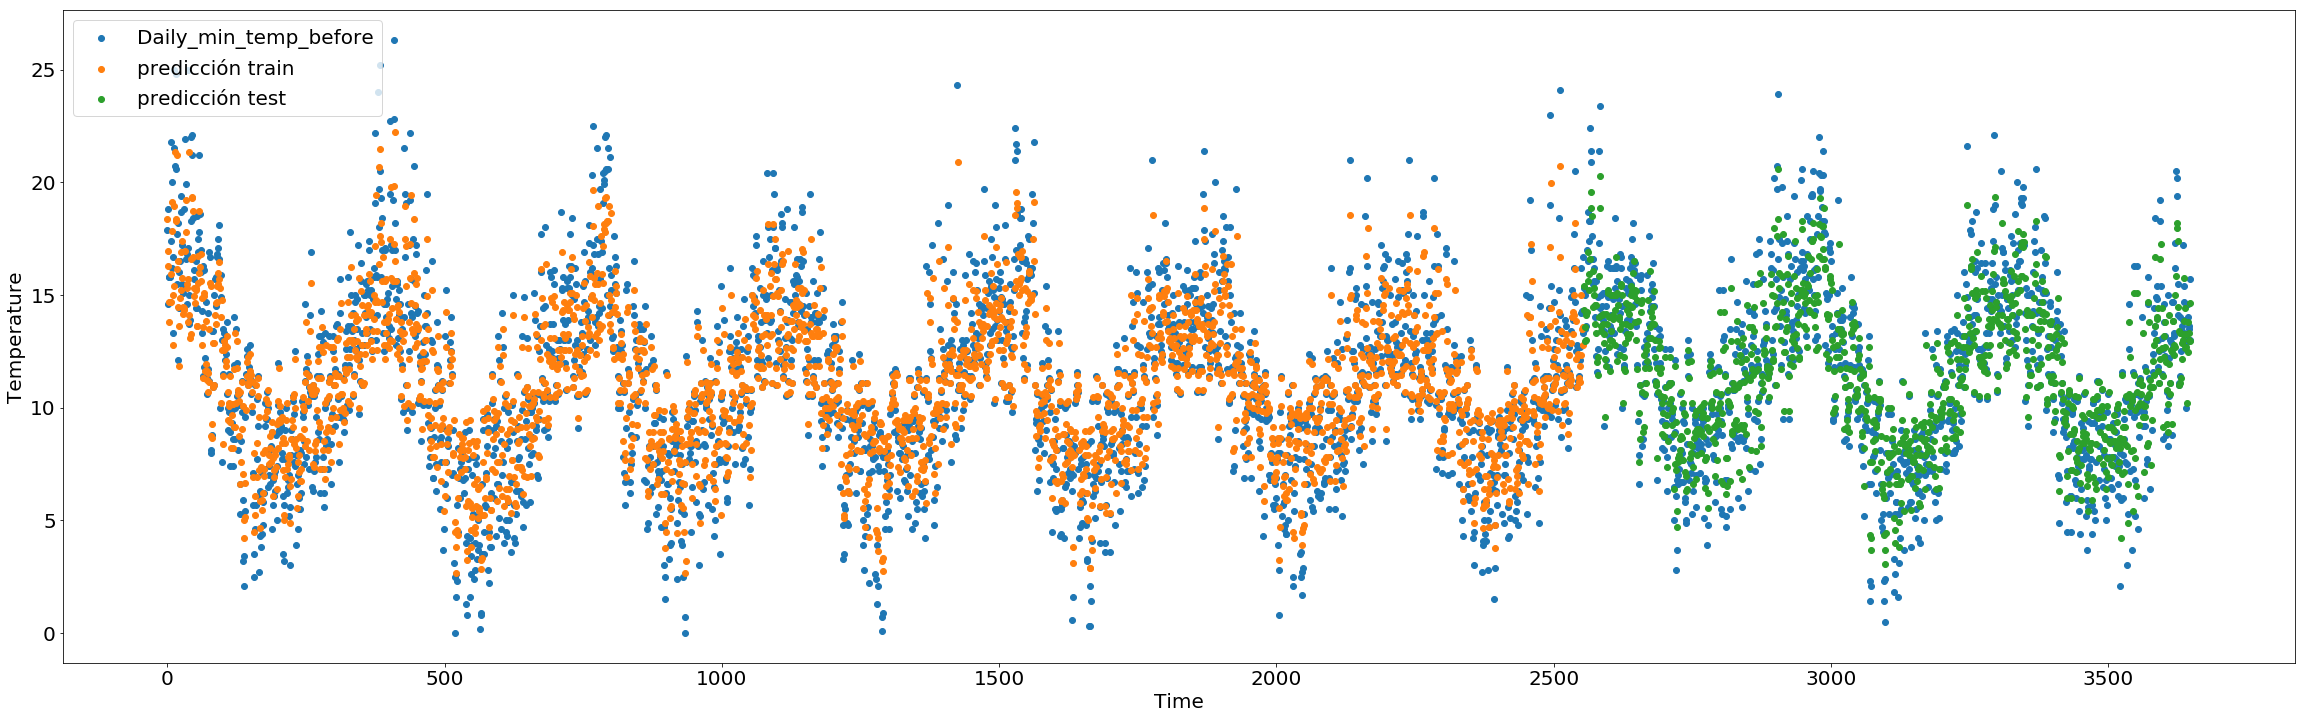

In [29]:
matplotlib.pyplot.scatter(range(y.shape[0]),y);
matplotlib.pyplot.scatter(range(train_pred.shape[0]),train_pred, label="predicción train");
matplotlib.pyplot.scatter(range(test_pred_plot.shape[0]),test_pred_plot, label="predicción test");
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(loc=2)
print('')